In [1]:
# Importing libraries
import csv
from matplotlib import pyplot as plt
import collections
import threading
import time

The class Pregel is designed to simulate a distributed system for graph processing, inspired by Google's Pregel architecture

**Purpose of the Pregel Class :**    

**Distributed Graph Processing:** The Pregel system is meant for efficient large-scale graph processing. It is structured to handle computations in which data is represented as a graph. Examples of such computations include calculating the shortest paths, PageRank, and more complex algorithms like clustering and graph analytics.

**Vertex-Centric Computation:** Each vertex in the graph executes the same algorithm in parallel, using its local data and messages received from other vertices. This model allows for highly scalable and distributed computations.

In [14]:
class Pregel():

    def __init__(self,vertices,num_workers):
        self.vertices = vertices
        self.num_workers = num_workers

    # Runs the Pregel instance
    def run(self):
        """"""
        self.partition = self.partition_vertices()
        while self.check_active():
            self.superstep()
            self.redistribute_messages()

    # Returns a dict with keys 0,...,self.num_workers-1 representing the worker threads.
    # The corresponding values are lists of vertices assigned to that worker.
    def partition_vertices(self):
        partition = collections.defaultdict(list)
        each = len(self.vertices) // self.num_workers

        for i in range(self.num_workers):
            partition[i] = self.vertices[i*each: (i+1)*each]

            if i == self.num_workers-1:
                partition[i] = self.vertices[i*each: ]

        return partition

    # Represents a single iteration of the computation across all vertices
    def superstep(self):
        workers = []
        for vertex_list in self.partition.values():
            worker = Worker(vertex_list)
            workers.append(worker)
            #print(f" Worker started with vertices list : {[v.id for v in vertex_list]}")
            worker.start()
        for worker in workers:
            worker.join()

    # Updates the message lists for all vertices.
    def redistribute_messages(self):
        for vertex in self.vertices:
            vertex.superstep +=1
            vertex.incoming_messages = []
        for vertex in self.vertices:
            for (receiving_vertix,message) in vertex.outgoing_messages:
                receiving_vertix.incoming_messages.append((vertex,message))

    # Returns True if there are any active vertices, and False otherwise.
    def check_active(self):
        return any([vertex.active for vertex in self.vertices])

The Worker class is a Python thread that is responsible for processing a subset of vertices in a graph, as part of the Pregel framework for distributed graph computation.

In [3]:
class Worker(threading.Thread):

    def __init__(self,vertices):
        threading.Thread.__init__(self)
        self.vertices = vertices

    def run(self):
        self.superstep()

    # Completes a single superstep for all the vertices in self.
    def superstep(self):
        for vertex in self.vertices:
            if vertex.active:
                vertex.update() # main TrustRank computation is done here only

In [4]:
class Vertex():

    def __init__(self,id,value,out_vertices):
        self.id = id
        self.value = value
        self.out_vertices = out_vertices
        self.incoming_messages = []
        self.outgoing_messages = []
        self.active = True
        self.superstep = 0

In [5]:
# Trust Rank Vertex Algo
class TrustRankVertex(Vertex):

    def __init__(self,id,value,out_vertices,d_score, dampingFactor=0.85,iterations=50):
        Vertex.__init__(self,id,value,out_vertices)
        self.dampingFactor = dampingFactor
        self.num_supersteps = iterations
        self.d_score = d_score

    def update(self):

        if self.superstep < self.num_supersteps:
            message_sum = 0
            for (vertex,message) in self.incoming_messages:
                message_sum = message_sum+message
            self.value = (1-self.dampingFactor)*self.d_score + self.dampingFactor*message_sum
            total_weight = 0.0
            for (vertex,weight) in self.out_vertices:
                total_weight+=weight
            self.outgoing_messages = [(vertex,self.value*(weight/total_weight)) for (vertex,weight) in self.out_vertices]
        else:
            self.active = False

In [6]:
# List of Nodes
def node_list(file_name):
    with open(file_name, mode ='r')as file:
        csvFile = csv.reader(file)
        # displaying the contents of the CSV file
        s = set()
        weights = dict()
        i = True
        for lines in csvFile:
            if i:
               i= False
               continue
            s.add(int(lines[0]))
            s.add(int(lines[1]))
            tup = (int(lines[0]),int(lines[1]))
            if tup not in weights:
                weights[tup] = float(lines[2])
            else:
                weights[tup]+=float(lines[2])

        nodes = [i for i in s]
        nodes = sorted(nodes)
        return [weights,nodes]

In [7]:
# Reading bad nodes
def read_bad_nodes(filename):
     with open(filename, mode ='r')as file:
        csvFile = csv.reader(file)
        # displaying the contents of the CSV file
        s = set()
        i = True
        for lines in csvFile:
            if i:
               i= False
               continue
            s.add(int(lines[0]))
        return s

In [8]:
# Calculating Trust Score
def cal_trust_scores(nodes, bad_nodes):
    scores = []
    total = 0
    for i in nodes:
        if i in bad_nodes:
            scores.append(1)
            total+=1
        else:
            scores.append(0)

    scores = [i/total for i in scores]
    return scores

In [9]:
# Updating Out Going Vertices
def updateOutGoingVertices(vertex, weights):
    for i in weights:
        fro = i[0]
        to = i[1]
        for v in vertex:
                for u in vertex:
                    if v.id == fro and u.id == to:
                        v.out_vertices.append((u,weights[i]))

In [10]:
# Pregel Trust Rank
def pregelTrustrank(vertices):
    p = Pregel(vertices,num_workers)
    p.run()
    return [(vertex.id, vertex.value) for vertex in p.vertices]

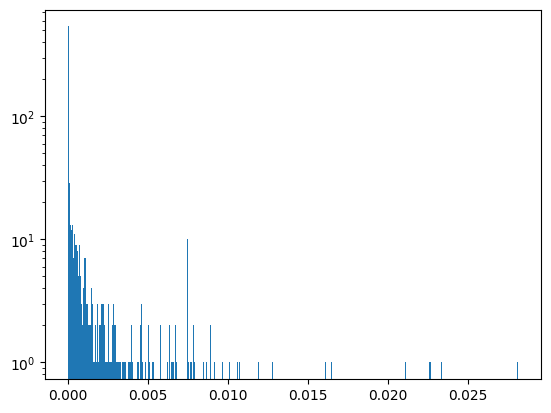

In [15]:
num_workers = 4
weights,nodes = node_list('Payments.csv')
bad_nodes = read_bad_nodes('bad_sender.csv')
trust_vector = cal_trust_scores(nodes,bad_nodes)

vertices = []
for i in range(len(nodes)):
    vertices.append(TrustRankVertex(nodes[i],trust_vector[i],[],trust_vector[i],0.85,20))

updateOutGoingVertices(vertices, weights)

node_trust_ranks = pregelTrustrank(vertices)

ans = [i[1] for i in node_trust_ranks]
plt.hist(ans, bins = 'auto')
plt.yscale('log')
plt.show()

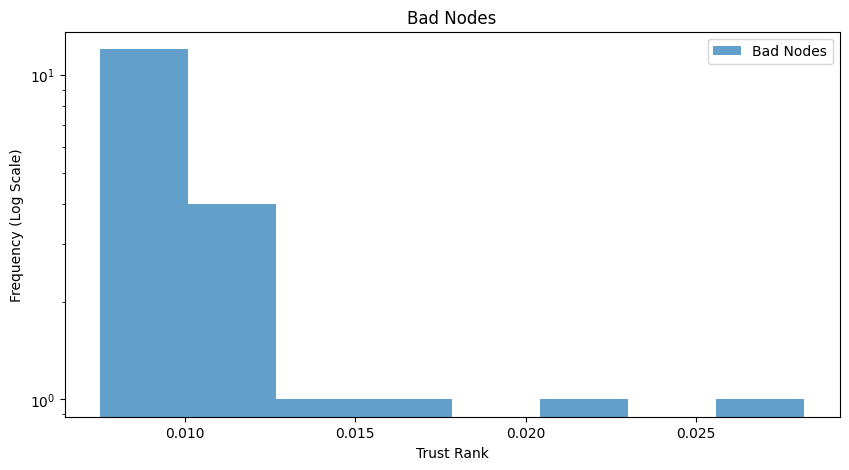

In [16]:
import matplotlib.pyplot as plt

# Splitting the trust ranks into good and bad based on the node ID presence in the bad_nodes set.
bad_trust_ranks = [rank for (node_id, rank) in node_trust_ranks if node_id in bad_nodes]

# Plotting histograms bad nodes
plt.figure(figsize=(10, 5))
plt.hist(bad_trust_ranks, bins='auto', alpha=0.7, label='Bad Nodes')
plt.yscale('log')
plt.xlabel('Trust Rank')
plt.ylabel('Frequency (Log Scale)')
plt.title('Bad Nodes')
plt.legend()
plt.show()